In [1]:
import keras
import json
import glob, os
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from io import BytesIO
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tqdm.keras import TqdmCallback
from tqdm.auto import trange, tqdm

Using TensorFlow backend.


In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
BATCH_SIZE = 1
EPOCHS = 500
IMG_ROWS, IMG_COLS = 256, 256
SAVE_RATE = 100

In [4]:
class Generator(Sequence) :
    def __init__(self, image_filenames, batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        X = []
        Y = []
        for file in batch_x:
            name = file[21:-4]
            X.append(np.load(file) / 255.0)
            Y.append(np.load("./decodedArray/bit_{0}/{1}.npy".format(STEN_X, name)) / 255.0)
        X = np.asarray(X)
        Y = np.asarray(Y)
        return X, Y

In [5]:
def generate_images(model, cover_imgs, hidden_imgs, encoded_imgs, decoded_imgs, save_name):
    fig, axs = plt.subplots(len(cover_imgs), 5, figsize=(15,15))
    cols = ["Cover", "Hidden", "Encoded", "Decoded", "Predicted"]
    for x in range(len(cover_imgs)):
        predicted = model.predict(np.asarray([encoded]))
        display_list = [cover_imgs[x], hidden_imgs[x], encoded_imgs[x], decoded_imgs[x], predicted[0]]
        [axs[x, y].imshow(display_list[y] * 0.5 + 0.5) for y in range(5)]
    [ax.set_title(col) for ax, col in zip(axs[0], cols)]
    [axi.set_axis_off() for axi in axs.ravel()]
    fig.tight_layout()
    plt.show()
    fig.savefig(save_name)

In [6]:
shape=(IMG_ROWS, IMG_COLS, 3)

In [7]:
autoencoder = Sequential()

autoencoder.add(Conv2D(64, (8, 8), padding='same', input_shape=shape))
autoencoder.add(Activation('relu'))
autoencoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

autoencoder.add(Conv2D(32,(5, 5), padding='same'))
autoencoder.add(Activation('relu'))
autoencoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

autoencoder.add(Conv2D(32,(5, 5), padding='same'))
autoencoder.add(Activation('relu'))
autoencoder.add(UpSampling2D((2, 2)))

autoencoder.add(Conv2D(64,(8, 8), padding='same'))
autoencoder.add(Activation('relu'))
autoencoder.add(UpSampling2D((2, 2)))

autoencoder.add(Conv2D(3,(3, 3), padding='same'))
autoencoder.add(Activation('sigmoid'))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      12352     
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      51232     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        2

In [9]:
# checkpoint_path = "checkpoints/autoencoder"
# ckpt = tf.train.Checkpoint(autoencoder=autoencoder)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [10]:
# for epoch in trange(EPOCHS, desc='Outer Epoch'):
#     STEN_X = np.random.randint(5, 8)
#     files = glob.glob("./encodedArray/bit_{0}/*".format(STEN_X))
#     train, val, test = np.split(files, [int(len(files)*0.8), int(len(files)*0.9)])
#     train_gen = Generator(train, BATCH_SIZE)
#     val_gen = Generator(val, BATCH_SIZE)
#     autoencoder.fit_generator(generator=train_gen,
#                         epochs = 10,
#                         verbose = 0,
#                         shuffle = True,
#                         validation_data = val_gen,
#                         callbacks=[TqdmCallback(verbose=2)])
# #     if (epoch + 1) % SAVE_RATE == 0:
# #         ckpt_manager.save()

Epoch 1/500
50/50 [==============================] - 3s 58ms/step - loss: 0.6899 - acc: 0.0123
Epoch 2/500
50/50 [==============================] - 1s 23ms/step - loss: 0.6889 - acc: 0.0124
Epoch 3/500
50/50 [==============================] - 1s 23ms/step - loss: 0.6880 - acc: 0.0125
Epoch 4/500
50/50 [==============================] - 1s 23ms/step - loss: 0.6873 - acc: 0.0125
Epoch 5/500
50/50 [==============================] - 1s 23ms/step - loss: 0.6865 - acc: 0.0126
Epoch 6/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6858 - acc: 0.0126
Epoch 7/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6852 - acc: 0.0126
Epoch 8/500
50/50 [==============================] - 1s 23ms/step - loss: 0.6846 - acc: 0.0126
Epoch 9/500
50/50 [==============================] - 1s 23ms/step - loss: 0.6840 - acc: 0.0126
Epoch 10/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6834 - acc: 0.0126
Epoch 11/500
50/50 [=============================

50/50 [==============================] - 1s 24ms/step - loss: 0.6589 - acc: 0.0136
Epoch 86/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6584 - acc: 0.0136
Epoch 87/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6579 - acc: 0.0137
Epoch 88/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6573 - acc: 0.0137
Epoch 89/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6566 - acc: 0.0138: 0s - loss: 0.6556 - acc: 0.
Epoch 90/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6560 - acc: 0.0138
Epoch 91/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6554 - acc: 0.0138
Epoch 92/500
50/50 [==============================] - 1s 23ms/step - loss: 0.6548 - acc: 0.0139
Epoch 93/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6541 - acc: 0.0139
Epoch 94/500
50/50 [==============================] - 1s 24ms/step - loss: 0.6535 - acc: 0.0139
Epoch 95/500
50/50 [====

50/50 [==============================] - 1s 24ms/step - loss: 0.5762 - acc: 0.0137
Epoch 169/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5756 - acc: 0.0137: 0s - loss: 0.5738 - acc: 0.
Epoch 170/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5749 - acc: 0.0137
Epoch 171/500
50/50 [==============================] - 1s 23ms/step - loss: 0.5744 - acc: 0.0137
Epoch 172/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5737 - acc: 0.0136
Epoch 173/500
50/50 [==============================] - 1s 23ms/step - loss: 0.5732 - acc: 0.0137
Epoch 174/500
50/50 [==============================] - 1s 23ms/step - loss: 0.5727 - acc: 0.0137
Epoch 175/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5721 - acc: 0.0137
Epoch 176/500
50/50 [==============================] - 1s 23ms/step - loss: 0.5717 - acc: 0.0137
Epoch 177/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5712 - acc: 0.0137
Epoch 178/500
5

50/50 [==============================] - 1s 24ms/step - loss: 0.5532 - acc: 0.0141
Epoch 251/500
50/50 [==============================] - 1s 23ms/step - loss: 0.5530 - acc: 0.0141
Epoch 252/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5529 - acc: 0.0141
Epoch 253/500
50/50 [==============================] - 1s 23ms/step - loss: 0.5528 - acc: 0.0141
Epoch 254/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5526 - acc: 0.0141
Epoch 255/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5526 - acc: 0.0141
Epoch 256/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5524 - acc: 0.0141
Epoch 257/500
50/50 [==============================] - 1s 23ms/step - loss: 0.5523 - acc: 0.0141
Epoch 258/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5521 - acc: 0.0141
Epoch 259/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5520 - acc: 0.0141
Epoch 260/500
50/50 [=======================

50/50 [==============================] - 1s 24ms/step - loss: 0.5450 - acc: 0.0144
Epoch 334/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5449 - acc: 0.0144
Epoch 335/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5448 - acc: 0.0144
Epoch 336/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5448 - acc: 0.0144
Epoch 337/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5447 - acc: 0.0144
Epoch 338/500
50/50 [==============================] - 1s 23ms/step - loss: 0.5446 - acc: 0.0144
Epoch 339/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5445 - acc: 0.0144
Epoch 340/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5445 - acc: 0.0144
Epoch 341/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5444 - acc: 0.0144
Epoch 342/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5443 - acc: 0.0144
Epoch 343/500
50/50 [=======================

50/50 [==============================] - 1s 24ms/step - loss: 0.5405 - acc: 0.0146
Epoch 418/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5405 - acc: 0.0146
Epoch 419/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5405 - acc: 0.0146
Epoch 420/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5404 - acc: 0.0146
Epoch 421/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5404 - acc: 0.0146
Epoch 422/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5404 - acc: 0.0146
Epoch 423/500
50/50 [==============================] - 1s 23ms/step - loss: 0.5403 - acc: 0.0146
Epoch 424/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5403 - acc: 0.0146
Epoch 425/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5402 - acc: 0.0146
Epoch 426/500
50/50 [==============================] - 1s 24ms/step - loss: 0.5402 - acc: 0.0146
Epoch 427/500
50/50 [=======================

50/50 [==============================] - 1s 24ms/step - loss: 0.5380 - acc: 0.0146


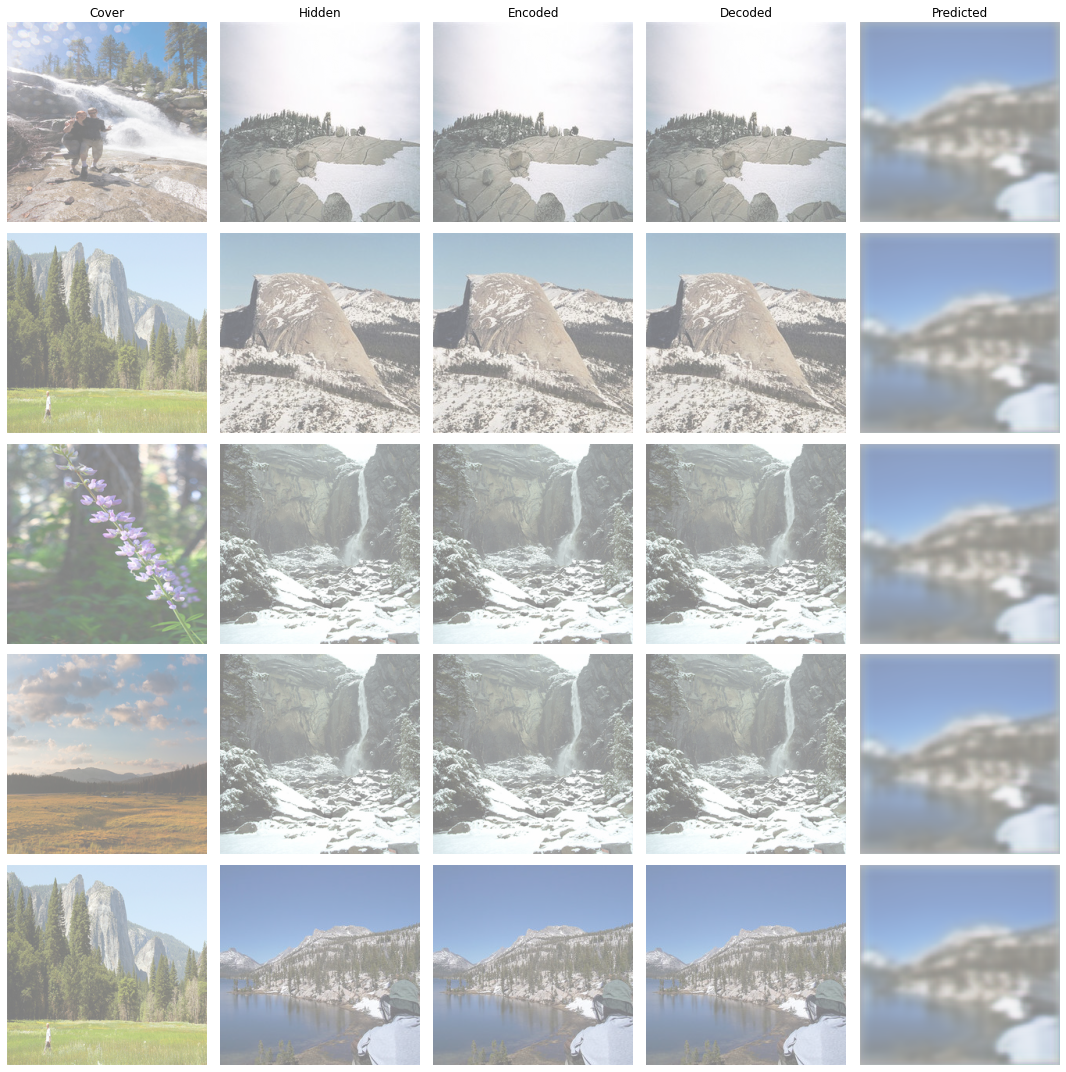

'checkpoints/autoencoder_8/ckpt-1'

In [11]:
STEN_X = 8

files = glob.glob("./encodedArray/bit_{0}/*".format(STEN_X))
train = files
train_gen = Generator(train, BATCH_SIZE)
autoencoder.fit_generator(generator=train_gen,
                    epochs = EPOCHS,
                    verbose = 1,
                    shuffle = True)

cover_imgs = np.empty((0, 256, 256, 3))
hidden_imgs = np.empty((0, 256, 256, 3))
encoded_imgs = np.empty((0, 256, 256, 3))
decoded_imgs = np.empty((0, 256, 256, 3))
for _ in range(5):
    set_1 = np.random.randint(1,11)
    set_2 = np.random.randint(1,6)
    name = str(set_1) + '_' + str(set_2)
    cover = mpimg.imread(os.getcwd() + "/data/set1/{0}.jpg".format(set_1)) / 255.0
    hidden = mpimg.imread(os.getcwd() + "/data/set2/{0}.jpg".format(set_2)) / 255.0
    encoded = np.load(os.getcwd() + "/encodedArray/bit_{0}/{1}.npy".format(STEN_X, name)) / 255.0
    decoded = np.load(os.getcwd() + "/decodedArray/bit_{0}/{1}.npy".format(STEN_X, name)) / 255.0
    cover_imgs = np.row_stack((cover_imgs, np.asarray([cover])))
    hidden_imgs = np.row_stack((hidden_imgs, np.asarray([hidden])))
    encoded_imgs = np.row_stack((encoded_imgs, np.asarray([encoded])))
    decoded_imgs = np.row_stack((decoded_imgs, np.asarray([decoded])))
    
generate_images(autoencoder, cover_imgs, hidden_imgs, encoded_imgs, decoded_imgs, "sten_{}.png".format(STEN_X))

checkpoint_path = "checkpoints/autoencoder_{0}".format(STEN_X)
ckpt = tf.train.Checkpoint(autoencoder=autoencoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)
ckpt_manager.save()